In [121]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from scipy import stats
from scipy.stats import norm, skew
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,accuracy_score
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering, DBSCAN

from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor, RandomForestClassifier
from lightgbm import LGBMRegressor
from sklearn.pipeline import make_pipeline
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from pandas.api.types import CategoricalDtype
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV, Lasso, Ridge
import os
print(os.listdir('.'))
train = pd.read_csv('input2/train.csv')
test = pd.read_csv('input2/test.csv')

all_data = pd.concat((train, test), axis=0, sort=False).reset_index(drop=True)

['.ipynb_checkpoints', 'Analise_Variavel_Alley.ipynb', 'Analise_Variavel_MiscFeature.ipynb', 'Analise_Variavel_Qualidade_Piscina.ipynb', 'Fast_through_variables_categorical.ipynb', 'Fast_through_variables_numerical.ipynb', 'HousePriceV012-20200414.ipynb', 'input2']


In [122]:
# Preencher não informados com vazios.
train['FireplaceQu'] = train['FireplaceQu'].fillna('NA')
test['FireplaceQu'] = test['FireplaceQu'].fillna('NA')
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NA')

# Criando novas variaveis
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('NA')
all_data['FireplaceQu'] = all_data['FireplaceQu'].apply(lambda x:
                                                        5 if x in ['Ex'] else
                                                        4 if x in ['Gd'] else
                                                        3 if x in ['TA'] else
                                                        2 if x in ['Fa'] else
                                                        1 if x in ['Po'] 
                                                        else 0)
all_data['FireplaceQuFireplaces'] = all_data['FireplaceQu'] * all_data['Fireplaces'] 



# Lotfrontage
dbfilter = all_data[['LotArea','LotFrontage']].copy()
X = dbfilter.iloc[:, [0,0]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
all_data['ClusterLotArea'] = y_hc
all_data["LotFrontage"] = all_data.groupby("ClusterLotArea")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

all_data.loc[all_data.index==2126, "GarageFinish"]='Unf'
all_data.loc[all_data.index==2126, "GarageQual"]='Po'
all_data.loc[all_data.index==2126, "GarageYrBlt"]=all_data[all_data["GarageQual"]=='Po']['GarageYrBlt'].min()
all_data.loc[all_data.index==2126, "GarageCond"]='Po'
all_data.loc[all_data.index==2576, "GarageCars"]=0
all_data.loc[all_data.index==2576, "GarageArea"]=0
all_data['GarageFinish'] = all_data['GarageFinish'].fillna('NA')
all_data['GarageQual'] = all_data['GarageQual'].fillna('NA')
all_data['GarageCond'] = all_data['GarageCond'].fillna('NA')
all_data['GarageType'] = all_data['GarageType'].fillna('NA')
all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)

all_data.loc[all_data.index.isin([2348,1487,948]), "BsmtExposure"]='Av'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtCond'].isnull()), "BsmtCond"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtQual'].isnull()), "BsmtQual"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtFinType2'].isnull()), "BsmtFinType2"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtFinType1'].isnull()), "BsmtFinType1"] = 'NA'
all_data.loc[(all_data['BsmtFinSF1']==0) & (all_data['BsmtExposure'].isnull()), "BsmtExposure"] = 'NA'
all_data.loc[all_data.index==2120,['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFullBath', 'BsmtHalfBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']] = all_data[(all_data.index==1856)][['BsmtExposure','BsmtCond','BsmtQual','BsmtFinType2','BsmtFinType1','BsmtFullBath','BsmtHalfBath','BsmtUnfSF','BsmtFinSF2','BsmtFinSF1']].values
all_data.loc[(all_data.index==2040), "BsmtCond"]='Gd'
all_data.loc[(all_data.index==2185), "BsmtCond"]='TA'
all_data.loc[(all_data.index==2524), "BsmtCond"]='TA'
all_data['TotalBsmtSF'] = all_data['TotalBsmtSF'].fillna(0)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].fillna('Unf')
all_data['BsmtFullBath'] = all_data['BsmtFullBath'].fillna(0)
all_data['BsmtHalfBath'] = all_data['BsmtHalfBath'].fillna(0)
all_data['MasVnrType'] = all_data['MasVnrType'].fillna('None')
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
all_data.loc[(all_data.index.isin([2216,2904])), "MSZoning"]='RL'
all_data.loc[(all_data.index.isin([1915,2250])), "MSZoning"]='RM'
all_data['Utilities'] = all_data['Utilities'].fillna('ELO')
all_data['Functional'] = all_data['Functional'].fillna('Typ')
all_data['SaleType'] = all_data['SaleType'].fillna('WD')
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')
all_data['Exterior1st'] = all_data['Exterior1st'].fillna('Other')
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna('Other')
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

train = train.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','Street','Utilities'], 1).copy()
test = test.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','Street','Utilities'], 1).copy()
all_data = all_data.drop(['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','Fireplaces','ClusterLotArea','Street','Utilities'], 1).copy()

# deletado por fraco porder de separação 
all_data = all_data.drop(['LandSlope','Condition1','Condition2','RoofStyle','RoofMatl',
                          'RoofMatl','BsmtFinType2','Heating', 'Electrical','Functional', 'GarageCond', 
                          'SaleType','SaleCondition'], 1).copy()

In [123]:
# Ajustes de classificações
all_data.loc[(all_data['MSZoning']=='RM'), "MSZoning"] = 'RH'

all_data.loc[(all_data['LotShape']=='IR3'), "LotShape"] = 'IR2'

all_data.loc[(all_data['LandContour']=='Low'), "LandContour"] = 'HLS'

all_data.loc[(all_data['LotConfig']=='FR2'), "LotConfig"] = 'Corner'
all_data.loc[(all_data['LotConfig']=='FR3'), "LotConfig"] = 'CulDSac'

# SEPARACAO DOS BAIRROS
dbfilter = all_data[(~all_data['Neighborhood'].isnull()) & (all_data['SalePrice'] > 0)][['Neighborhood','SalePrice']].copy()
dbfilter['media']=all_data['Neighborhood'].map(dbfilter.groupby(["Neighborhood"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Neighborhood')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Neighborhood'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Neighborhood'].max().copy()
all_data['Neighborhood'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

"""
dbfilter2 = train.groupby('Neighborhood')['SalePrice'].median().to_frame(name = 'MediaBairro').reset_index().sort_values('MediaBairro',ascending=True).copy()
X = dbfilter2.iloc[:, [1,1]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 6, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['ClusterBairro'] = y_hc
#grafico['ClusterBairroGrupo'] = all_data.groupby("ClusterBairro")["LotFrontage"].transform(
#    lambda x: x.fillna(x.median()))
dbfilter2['ClusterValue'] = dbfilter2['ClusterBairro'].map(dbfilter2.groupby('ClusterBairro')['MediaBairro'].max()).copy()
dbfilter3 = dbfilter2[(dbfilter2['MediaBairro']==dbfilter2['ClusterValue'])][['ClusterBairro', 'Neighborhood']]
dbfilter3 = dbfilter3.set_index('ClusterBairro').copy()
dbfilter4 = dbfilter2.set_index('Neighborhood').copy()
mean_encode = dbfilter4['ClusterBairro']
all_data['ClusterBairro'] = all_data['Neighborhood'].map(mean_encode)
all_data['Neighborhood'] = all_data['ClusterBairro'].map(dbfilter3['Neighborhood'])
all_data = all_data.drop(['ClusterBairro'], 1).copy()
"""

all_data.loc[(all_data['BldgType']=='2fmCon'), "BldgType"] = 'Duplex'
all_data.loc[(all_data['BldgType']=='Twnhs'), "BldgType"] = 'Duplex'
all_data.loc[(all_data['BldgType']=='TwnhsE'), "BldgType"] = '1Fam'

#SEPARACAO DOS HouseStyle
dbfilter = all_data[(~all_data['HouseStyle'].isnull()) & (all_data['SalePrice'] > 0)][['HouseStyle','SalePrice']].copy()
dbfilter['media']=all_data['HouseStyle'].map(dbfilter.groupby(["HouseStyle"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('HouseStyle')['Cluster'].max().copy()
all_data['Cluster'] = all_data['HouseStyle'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['HouseStyle'].max().copy()
all_data['HouseStyle'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Exterior1st
dbfilter = all_data[(~all_data['Exterior1st'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior1st','SalePrice']].copy()
dbfilter['media']=all_data['Exterior1st'].map(dbfilter.groupby(["Exterior1st"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior1st')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior1st'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior1st'].max().copy()
all_data['Exterior1st'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Exterior2nd
dbfilter = all_data[(~all_data['Exterior2nd'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior2nd','SalePrice']].copy()
dbfilter['media']=all_data['Exterior2nd'].map(dbfilter.groupby(["Exterior2nd"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior2nd')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior2nd'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior2nd'].max().copy()
all_data['Exterior2nd'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['MasVnrType']=='BrkCmn'), "MasVnrType"] = 'None'

# separacao Exterior2nd
dbfilter = all_data[(~all_data['ExterCond'].isnull()) & (all_data['SalePrice'] > 0)][['ExterCond','SalePrice']].copy()
dbfilter['media']=all_data['ExterCond'].map(dbfilter.groupby(["ExterCond"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 2, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('ExterCond')['Cluster'].max().copy()
all_data['Cluster'] = all_data['ExterCond'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['ExterCond'].max().copy()
all_data['ExterCond'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao Foundation
dbfilter = all_data[(~all_data['Foundation'].isnull()) & (all_data['SalePrice'] > 0)][['Foundation','SalePrice']].copy()
dbfilter['media']=all_data['Foundation'].map(dbfilter.groupby(["Foundation"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Foundation')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Foundation'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Foundation'].max().copy()
all_data['Foundation'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['BsmtQual']=='BrkCmn'), "BsmtQual"] = 'None'
all_data.loc[(all_data['BsmtExposure']=='Mn'), "BsmtExposure"] = 'Av'

# separacao BsmtFinType1
dbfilter = all_data[(~all_data['BsmtFinType1'].isnull()) & (all_data['SalePrice'] > 0)][['BsmtFinType1','SalePrice']].copy()
dbfilter['media']=all_data['BsmtFinType1'].map(dbfilter.groupby(["BsmtFinType1"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('BsmtFinType1')['Cluster'].max().copy()
all_data['Cluster'] = all_data['BsmtFinType1'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['BsmtFinType1'].max().copy()
all_data['BsmtFinType1'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao HeatingQC
dbfilter = all_data[(~all_data['HeatingQC'].isnull()) & (all_data['SalePrice'] > 0)][['HeatingQC','SalePrice']].copy()
dbfilter['media']=all_data['HeatingQC'].map(dbfilter.groupby(["HeatingQC"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('HeatingQC')['Cluster'].max().copy()
all_data['Cluster'] = all_data['HeatingQC'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['HeatingQC'].max().copy()
all_data['HeatingQC'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao GarageType
dbfilter = all_data[(~all_data['GarageType'].isnull()) & (all_data['SalePrice'] > 0)][['GarageType','SalePrice']].copy()
dbfilter['media']=all_data['GarageType'].map(dbfilter.groupby(["GarageType"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('GarageType')['Cluster'].max().copy()
all_data['Cluster'] = all_data['GarageType'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['GarageType'].max().copy()
all_data['GarageType'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao GarageQual
dbfilter = all_data[(~all_data['GarageQual'].isnull()) & (all_data['SalePrice'] > 0)][['GarageQual','SalePrice']].copy()
dbfilter['media']=all_data['GarageQual'].map(dbfilter.groupby(["GarageQual"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('GarageQual')['Cluster'].max().copy()
all_data['Cluster'] = all_data['GarageQual'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['GarageQual'].max().copy()
all_data['GarageQual'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data.loc[(all_data['PavedDrive']=='P'), "PavedDrive"] = 'N'

# separacao MSSubClass
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str).apply(lambda x: 'MS'+x )
dbfilter = all_data[(~all_data['MSSubClass'].isnull()) & (all_data['SalePrice'] > 0)][['MSSubClass','SalePrice']].copy()
dbfilter['media']=all_data['MSSubClass'].map(dbfilter.groupby(["MSSubClass"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 5, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('MSSubClass')['Cluster'].max().copy()
all_data['Cluster'] = all_data['MSSubClass'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['MSSubClass'].max().copy()
all_data['MSSubClass'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

# separacao OverallCond
all_data['OverallCond'] = all_data['OverallCond'].apply(str).apply(lambda x: 'OC'+x )
dbfilter = all_data[(~all_data['OverallCond'].isnull()) & (all_data['SalePrice'] > 0)][['OverallCond','SalePrice']].copy()
dbfilter['media']=all_data['OverallCond'].map(dbfilter.groupby(["OverallCond"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('OverallCond')['Cluster'].max().copy()
all_data['Cluster'] = all_data['OverallCond'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['OverallCond'].max().copy()
all_data['OverallCond'] = all_data['Cluster'].map(mean_encode).copy()
all_data = all_data.drop(['Cluster'], 1).copy()

all_data['MoSold'] = all_data['MoSold'].apply(str).apply(lambda x: 'MS'+x )

"""

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#CRIANDO NOVAS VARIAVEIS (MELHOROU BEM COM NOVA VARIAVEL)
all_data['IsNew'] = np.where(all_data['YrSold'] == all_data['YearBuilt'], 1, 0)
all_data['Remod'] = np.where(all_data['YearBuilt'] == all_data['YearRemodAdd'], 0, 1)
all_data['Age'] = all_data['YrSold'] - all_data['YearRemodAdd']
all_data['Age'] = all_data['Age'].apply(lambda x: 0 if x < 0 
                                        else x)

#all_data['TotalPorchSF'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']

#all_data['TotalSqFeet'] = all_data['GrLivArea'] + all_data['TotalBsmtSF']

# Adding total sqfootage feature 
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
all_data['TotBathrooms'] = all_data['FullBath'] + (all_data['HalfBath']*0.5) + all_data['BsmtFullBath'] + (all_data['BsmtHalfBath']*0.5)

#arrumar ano que foi imputado errado
all_data.loc[all_data["GarageYrBlt"] == 2207, "GarageYrBlt"] = 2007
"""

'\n\n#Year and month sold are transformed into categorical features.\nall_data[\'YrSold\'] = all_data[\'YrSold\'].astype(str)\nall_data[\'MoSold\'] = all_data[\'MoSold\'].astype(str)\n\n#CRIANDO NOVAS VARIAVEIS (MELHOROU BEM COM NOVA VARIAVEL)\nall_data[\'IsNew\'] = np.where(all_data[\'YrSold\'] == all_data[\'YearBuilt\'], 1, 0)\nall_data[\'Remod\'] = np.where(all_data[\'YearBuilt\'] == all_data[\'YearRemodAdd\'], 0, 1)\nall_data[\'Age\'] = all_data[\'YrSold\'] - all_data[\'YearRemodAdd\']\nall_data[\'Age\'] = all_data[\'Age\'].apply(lambda x: 0 if x < 0 \n                                        else x)\n\n#all_data[\'TotalPorchSF\'] = all_data[\'OpenPorchSF\'] + all_data[\'EnclosedPorch\'] + all_data[\'3SsnPorch\'] + all_data[\'ScreenPorch\']\n\n#all_data[\'TotalSqFeet\'] = all_data[\'GrLivArea\'] + all_data[\'TotalBsmtSF\']\n\n# Adding total sqfootage feature \nall_data[\'TotalSF\'] = all_data[\'TotalBsmtSF\'] + all_data[\'1stFlrSF\'] + all_data[\'2ndFlrSF\']\nall_data[\'TotBathrooms

In [124]:
### CRIACAO DE VARIAVEIS NUMERICAS
all_data['TotalPorch'] = all_data['OpenPorchSF'] + all_data['EnclosedPorch'] + all_data['3SsnPorch'] + all_data['ScreenPorch']
all_data['BsmtBathTot'] = all_data['BsmtFullBath'] + (all_data['BsmtHalfBath']*0.5)
# deletado variaveis numericas
all_data = all_data.drop(['OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch', 'Id', 'BsmtUnfSF', 
                          'BsmtFinSF2', 'BsmtFinSF1','KitchenAbvGr', 'YrSold', 'MoSold','LowQualFinSF','MiscVal',
                         'GarageArea','1stFlrSF', 'BsmtFullBath','BsmtHalfBath'], 1).copy()


In [125]:
pd.set_option('display.max_columns', None)
numerical_cols = [cname for cname in all_data.columns if 
                    all_data[cname].dtype in ['int64', 'float64']]
all_data[numerical_cols]

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,WoodDeckSF,PoolArea,SalePrice,FireplaceQuFireplaces,TotalPorch,BsmtBathTot
0,65.0,8450,7,2003,2003,196.0,856.0,854,1710,2,1,3,8,2003.0,2.0,0,0,208500.0,0,61,1.0
1,80.0,9600,6,1976,1976,0.0,1262.0,0,1262,2,0,3,6,1976.0,2.0,298,0,181500.0,3,0,0.5
2,68.0,11250,7,2001,2002,162.0,920.0,866,1786,2,1,3,6,2001.0,2.0,0,0,223500.0,3,42,1.0
3,60.0,9550,7,1915,1970,0.0,756.0,756,1717,1,0,3,7,1998.0,3.0,0,0,140000.0,4,307,1.0
4,84.0,14260,8,2000,2000,350.0,1145.0,1053,2198,2,1,4,9,2000.0,3.0,192,0,250000.0,3,84,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,21.0,1936,4,1970,1970,0.0,546.0,546,1092,1,1,3,5,0.0,0.0,0,0,NaN,0,0,0.0
2915,21.0,1894,4,1970,1970,0.0,546.0,546,1092,1,1,3,6,1970.0,1.0,0,0,NaN,0,24,0.0
2916,160.0,20000,5,1960,1996,0.0,1224.0,0,1224,1,0,4,7,1960.0,2.0,474,0,NaN,3,0,1.0
2917,62.0,10441,5,1992,1992,0.0,912.0,0,970,1,0,3,6,0.0,0.0,80,0,NaN,0,32,0.5


In [127]:
dbfilter = all_data[(all_data['SalePrice'] > 0)][numerical_cols] 

#dbfilter = all_data[(~all_data['MoSold'].isnull()) & (all_data['SalePrice'] > 0)][['MoSold','SalePrice']] 
dbfilter

,LotFrontage,LotArea,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,GarageYrBlt,GarageCars,WoodDeckSF,PoolArea,SalePrice,FireplaceQuFireplaces,TotalPorch,BsmtBathTot
0,65.0,8450,7,2003,2003,196.0,856.0,854,1710,2,1,3,8,2003.0,2.0,0,0,208500.0,0,61,1.0
1,80.0,9600,6,1976,1976,0.0,1262.0,0,1262,2,0,3,6,1976.0,2.0,298,0,181500.0,3,0,0.5
2,68.0,11250,7,2001,2002,162.0,920.0,866,1786,2,1,3,6,2001.0,2.0,0,0,223500.0,3,42,1.0
3,60.0,9550,7,1915,1970,0.0,756.0,756,1717,1,0,3,7,1998.0,3.0,0,0,140000.0,4,307,1.0
4,84.0,14260,8,2000,2000,350.0,1145.0,1053,2198,2,1,4,9,2000.0,3.0,192,0,250000.0,3,84,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,62.0,7917,6,1999,2000,0.0,953.0,694,1647,2,1,3,7,1999.0,2.0,0,0,175000.0,3,40,0.0
1456,85.0,13175,6,1978,1988,119.0,1542.0,0,2073,2,0,3,7,1978.0,2.0,349,0,210000.0,6,0,1.0
1457,66.0,9042,7,1941,2006,0.0,1152.0,1152,2340,2,0,4,9,1941.0,1.0,0,0,266500.0,8,60,0.0
1458,68.0,9717,5,1950,1996,0.0,1078.0,0,1078,1,0,2,5,1950.0,1.0,366,0,142125.0,0,112,1.0


In [94]:
dbfilter['MoSold'].unique()

dbfilter.groupby(["MoSold"])["SalePrice"].count()

MoSold
MS1      58
MS10     89
MS11     79
MS12     59
MS2      52
MS3     106
MS4     141
MS5     204
MS6     253
MS7     234
MS8     122
MS9      63
Name: SalePrice, dtype: int64

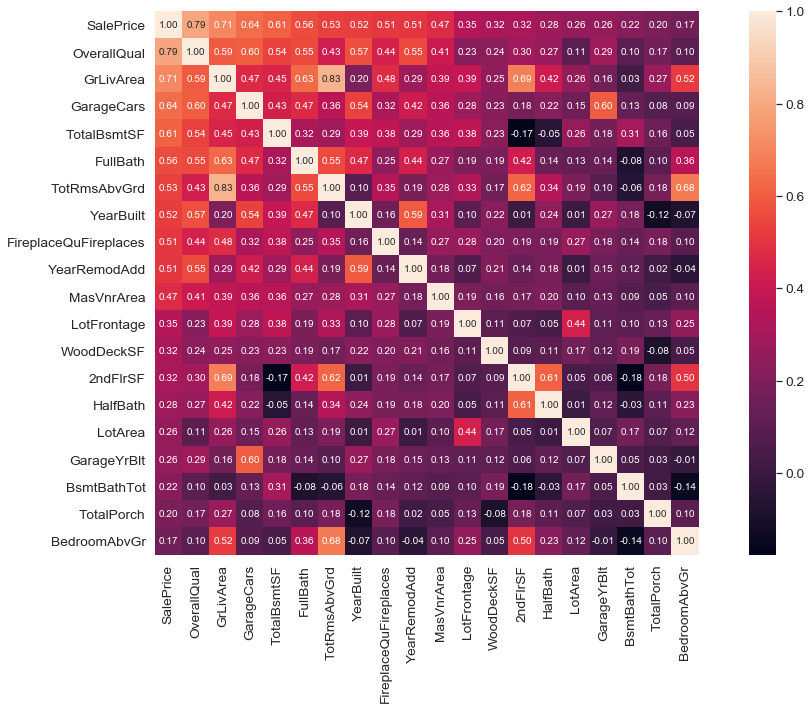

In [128]:
k = 20 #number of variables for heatmap
plt.figure(figsize=(18,10))
# LINHAS ABAIXO É PARA PEGAR DE 20 EM 20 E VERIFICAR CORRELAÇÃO DAS VARIAVEIS
#train20 = train.copy()
#train20 = train20.drop(cols,1)
#train20['SalePrice'] = train['SalePrice']
corrmat = dbfilter.corr()
# picking the top 15 correlated features nsmallest 
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(dbfilter[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [129]:
corrmat[['SalePrice']].sort_values(by=['SalePrice'], ascending=False)

,SalePrice
SalePrice,1.000000
OverallQual,0.790982
GrLivArea,0.708624
GarageCars,0.640409
TotalBsmtSF,0.613581
FullBath,0.560664
TotRmsAbvGrd,0.533723
YearBuilt,0.522897
FireplaceQuFireplaces,0.510043
YearRemodAdd,0.507101


In [112]:
dbfilter[['SalePrice','1stFlrSF','TotalBsmtSF']].corr().sort_values(by=['SalePrice'])

,SalePrice,1stFlrSF,TotalBsmtSF
1stFlrSF,0.605852,1.000000,0.819530
TotalBsmtSF,0.613581,0.819530,1.000000
SalePrice,1.000000,0.605852,0.613581


In [135]:
dbfilter2 = np.log1p(dbfilter).copy()
dbfilter3 = dbfilter2.corr().sort_values(by=['SalePrice'])
dbfilter3[['SalePrice']]

,SalePrice
PoolArea,0.069949
2ndFlrSF,0.180778
BedroomAbvGr,0.197664
BsmtBathTot,0.238369
TotalPorch,0.309608
HalfBath,0.320925
GarageYrBlt,0.326485
WoodDeckSF,0.343039
LotFrontage,0.364356
TotalBsmtSF,0.372838


In [95]:
mc = MultiComparison(dbfilter['SalePrice'], dbfilter['MoSold'])
result = mc.tukeyhsd()
 
print(result.summary())
print(mc.groupsunique)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower      upper    reject
--------------------------------------------------------------
   MS1   MS10  -3692.2811    0.9 -47583.9386 40199.3764  False
   MS1   MS11   8954.6528    0.9 -36019.7138 53929.0193  False
   MS1   MS12   3262.7075    0.9 -44830.6661 51356.0811  False
   MS1    MS2  -5374.2586    0.9  -55046.412 44297.8948  False
   MS1    MS3     -2.3341    0.9  -42482.608 42477.9398  False
   MS1    MS4 -11752.9962    0.9  -52325.826 28819.8336  False
   MS1    MS5  -10948.989    0.9 -49652.8133 27754.8353  False
   MS1    MS6  -5860.5234    0.9 -43725.5487 32004.5018  False
   MS1    MS7   3074.9337    0.9 -35075.7051 41225.5725  False
   MS1    MS8   1395.5692    0.9 -40087.8604 42878.9989  False
   MS1    MS9  12426.9477    0.9 -34903.5125  59757.408  False
  MS10   MS11  12646.9339    0.9 -27557.9124 52851.7801  False
  MS10   MS12   6954.9886    0.9  -36710.886 50620.8631

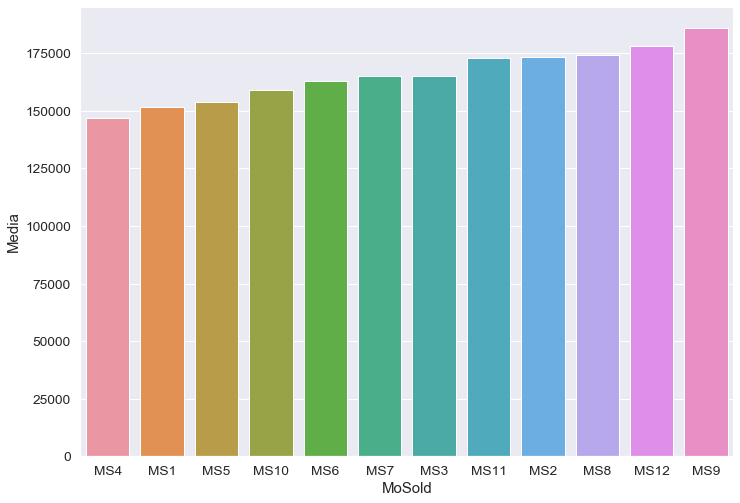

In [96]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
grafico = dbfilter.groupby('MoSold')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True) 
grafico
sns.barplot(ax=ax,data=grafico,x='MoSold', y='Media')

In [87]:
all_data[(all_data['PoolQC'] == 'Ex')][['PoolQC', 'SalePrice']]

,PoolQC,SalePrice
197,Ex,235000.0
1182,Ex,745000.0
1974,Ex,NaN
2573,Ex,NaN


In [170]:
dbfilter[(dbfilter['SalePrice']>0)].corr()

,FireplaceQu,SalePrice,Fireplaces,FireplaceQuFireplaces
FireplaceQu,1.000000,0.520438,0.863241,0.903035
SalePrice,0.520438,1.000000,0.466929,0.510043
Fireplaces,0.863241,0.466929,1.000000,0.961538
FireplaceQuFireplaces,0.903035,0.510043,0.961538,1.000000


array([[   65.,  8450.],
       [   80.,  9600.],
       [   68., 11250.],
       ...,
       [   66.,  9042.],
       [   68.,  9717.],
       [   75.,  9937.]])

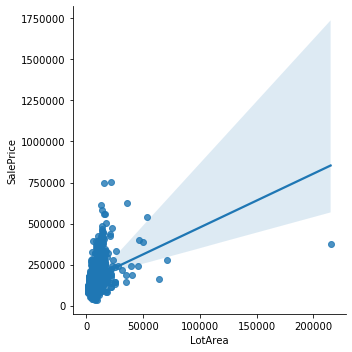

In [46]:
sns.lmplot(x='LotArea',y='SalePrice',data=dbfilter)
#sns.lmplot(x='LotFrontage',y='SalePrice',data=dbfilter)
dbfilter
dbfilter.iloc[:, [0,2]].values

In [631]:
"""
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(grafico['MediaBairro'], method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.show()
"""
all_data['Cluster'].map(mean_encode).copy()

0       VinylSd
1       Wd Sdng
2       VinylSd
3       Wd Shng
4       VinylSd
         ...   
2914      Other
2915      Other
2916    VinylSd
2917    Wd Shng
2918    Wd Shng
Name: Cluster, Length: 2919, dtype: object

In [629]:
dbfilter = all_data[(~all_data['Exterior2nd'].isnull()) & (all_data['SalePrice'] > 0)][['Exterior2nd','SalePrice']].copy()
dbfilter['media']=all_data['Exterior2nd'].map(dbfilter.groupby(["Exterior2nd"])["SalePrice"].mean())
dbfilter2 = dbfilter.copy()
#dbfilter2 = train.groupby('Exterior2nd')['SalePrice'].median().to_frame(name = 'Media').reset_index().sort_values('Media',ascending=True).copy()
#dbfilter2['media'] = np.log1p(dbfilter2['media']).copy()
X = dbfilter2.iloc[:, [2,2]].values
X = StandardScaler().fit_transform(X)
hc = AgglomerativeClustering(n_clusters = 3, affinity = 'euclidean', linkage ='ward')
y_hc=hc.fit_predict(X)
dbfilter2['Cluster'] = y_hc
mean_encode = dbfilter2.groupby('Exterior2nd')['Cluster'].max().copy()
all_data['Cluster'] = all_data['Exterior2nd'].map(mean_encode).copy()
mean_encode = dbfilter2.groupby('Cluster')['Exterior2nd'].max().copy()
all_data['Exterior2nd'] = all_data['Cluster'].map(mean_encode).copy()
mean_encode

Cluster
0    Wd Sdng
1    VinylSd
2    Wd Shng
3      Other
Name: Exterior2nd, dtype: object

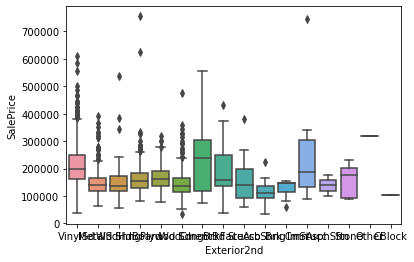

In [536]:
sns.boxplot(x='Exterior2nd',y='SalePrice',data=dbfilter)


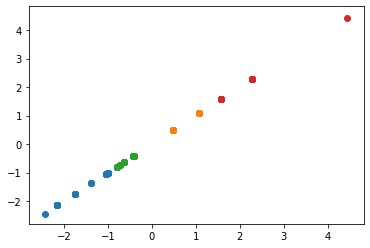

In [636]:
clusters = np.unique(y_hc)
# create scatter plot for samples from each cluster
for cluster in clusters:
    
    # get row indexes for samples with this cluster
    row_ix = np.where(y_hc == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 1], X[row_ix, 1])
# show the plot
plt.show()

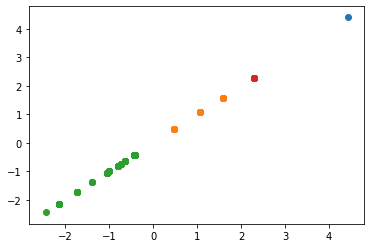

In [494]:
hc = DBSCAN(eps=0.9, min_samples=10)
y_hc=hc.fit_predict(X)
clusters = np.unique(y_hc)
# create scatter plot for samples from each cluster
for cluster in clusters:
    
    # get row indexes for samples with this cluster
    row_ix = np.where(y_hc == cluster)
    # create scatter of these samples
    plt.scatter(X[row_ix, 1], X[row_ix, 1])
# show the plot
plt.show()

In [741]:
for x,y in dbfilter2.groupby(['Cluster','ExterCond']):
    print(x)

(0, 'Ex')
(0, 'Gd')
(0, 'TA')
(1, 'Fa')
(1, 'Po')


In [186]:

all_data["LotFrontage"] = all_data.groupby("ClusterLotArea")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

In [58]:
y_hc

array([2, 2, 2, 5, 5, 5, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4,
       0, 0, 0], dtype=int64)

In [78]:

source = pd.DataFrame({'Country' : ['USA', 'USA', 'Russia','USA'], 
                  'City' : ['New-York', 'New-York', 'Sankt-Petersburg', 'New-York'],
                  'Short name' : ['NY','New','Spb','NY']})

source.groupby(['Country','City']).agg(lambda x:x.value_counts().index[0])

,,Short name
Country,City,
Russia,Sankt-Petersburg,Spb
USA,New-York,NY


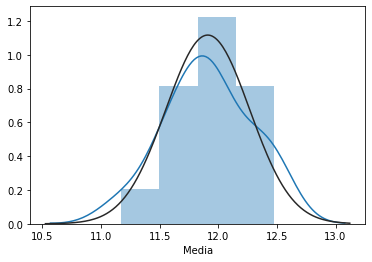

In [406]:

dbfilter2['Media'] = np.log1p(dbfilter2['Media']).copy()
sns.distplot(dbfilter2['Media'] , fit=norm);

In [450]:
all_data['Exterior2nd'].unique()

array(['Wd Shng', 'Other', 'CBlock'], dtype=object)

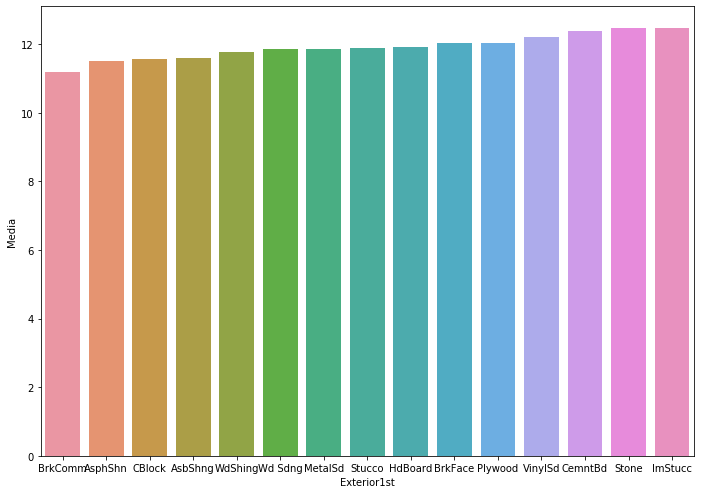

In [410]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax,data=dbfilter2,x='Exterior1st', y='Media')